# Generalised Linear Models and the maximum entropy principle 

#### Adapted from chapter 10 of Statistical Rethinking.

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from theano import shared
import arviz as az
import seaborn as sns
from IPython.display import display
from PIL import Image

#### On Maximum Entropy

#### Key idea, choose the distribution for the likelihood function which exhibits the largest entropy. 

#### Definition of information entropy. It is a measure which satisfies: 
##### (1) the measure should be continuous; 
##### (2) it should increase as the number of possible events increases;
##### (3) it should be additive

#### The resulting measure of uncertainty of a probability distribution $p$ with probabilities $p_{i}$ for each possible event $i$ is just the average log probability:
$$H(p) = - \sum_{i}p_{i}logp_{i}$$

#### A 'concise' statement of the principle:

##### The distribution that can happen the most ways is also the distribution with the biggest information entropy. The distribution with the biggest entropy is the most conservative distribution that obeys its constraints

#### Illustrative example from the book:
###### Imagine instead 5 buckets and a pile of 10 individually numbered pebbles. You stand and toss all 10 pebbles such that each pebble is equally likely to land in any of the 5 buckets. This means that every particular arrangement of the 10 individual pebbles is equally likely—it’s just as likely to get all 10 in bucket 3 as it is to get pebble 1 in bucket 2, pebbles 2–9 in bucket 3, and pebble 10 in bucket 4. But some kinds of arrangements are much more likely. Some arrangements look the same, because they show the same number of pebbles in the same individual buckets. These are distributions of pebbles. the below figure illustrates 5 such distributions. So for example there is only 1 way to arrange the individual pebbles so that all of them are in bucket 3 (plot A). But there are 90 ways to arrange the individual pebbles so that 2 of them are in bucket 2, 8 in bucket 3, and 2 in bucket 4 (plot B). Plots C, D, and E show that the number of unique arrangements corresponding to a distribution grows very rapidly as the distribution places a more equal number of pebbles in each bucket. By the time there are 2 pebbles in each bucket (plot E), there are 113400 ways to realize this distribution. There is no other distribution of the pebbles that can be realized a greater number of ways.

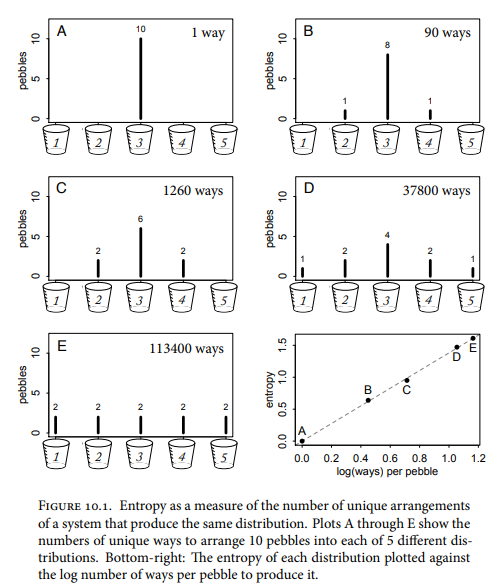

In [2]:
display(Image.open(os.path.join(os.getcwd(),r'data/entropy.png')))

In [3]:
# Put each distribution into an associative array

d = {'a': [0, 0, 10, 0, 0],
     'b': [0, 1, 8, 1, 0],
     'c': [0, 2, 6, 2, 0],
     'd': [1, 2, 4, 2, 1],
     'e': [2, 2, 2, 2, 2]}

p = pd.DataFrame(d)
# normalise to valid probability distribution
p_norm = p/p.sum(axis=0)

In [4]:
p_norm

,a,b,c,d,e
0,0.0,0.0,0.0,0.1,0.2
1,0.0,0.1,0.2,0.2,0.2
2,1.0,0.8,0.6,0.4,0.2
3,0.0,0.1,0.2,0.2,0.2
4,0.0,0.0,0.0,0.1,0.2


#### Since these are now probability distributions, we can compute the information entropy of each

In [5]:
def entropy(x):
    return -1*sum([0 if elem == 0 else elem*np.log(elem) for elem in x])

In [6]:
H = p_norm.apply(entropy, axis=0)
print(H)

a   -0.000000
b    0.639032
c    0.950271
d    1.470808
e    1.609438
dtype: float64


#### So distribution E, which can realized by far the greatest number of ways, also has the biggest entropy. This is no coincidence. To see why, let’s compute the logarithm of number of ways each distribution can be realized, then divide that logarithm by 10, the number of pebbles. This gives us the log ways per pebble for each distribution

In [7]:
ways = [1, 90, 1260, 37_800, 113_400]
logways = np.log(ways)/10
print(logways)

[0.         0.44998097 0.7138867  1.05400644 1.16386767]


#### The below plot displays these logwayspp values against the information entropies H. These two sets of values contain the same information, as information entropy is an approximation of the log ways per pebble. As the number of pebbles grows larger, the approximation gets better. It’s already extremely good, for just 10 pebbles. Information entropy is a way of counting how many unique arrangements correspond to a distribution

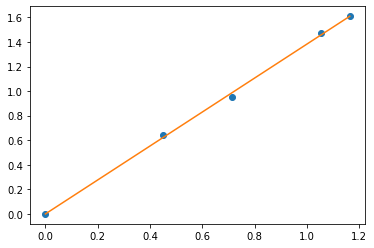

In [8]:
plt.plot(logways, H, "o")
plt.plot([0, max(logways)], [0,max(H)])

#### What is the relevant lesson here? The distribution that can happen the greatest number of ways is the most plausible distribution. Call this distribution the maximum entropy distribution.

### Entropy and the Binomial distribution

#### If two things can happen and there's a constant chance $p$ across $n$ trials, then the probability of observing $y$ events of type 1 and $n-y$ events of type 2 is:

$$Pr(y_{1}, y_{2}, ..., y_{n}|n, p) = p^y(1-p)^{(n-y)}$$

#### Now we want to demonstrate that this same distribution has the largest entropy of any distribution that satisfies these constraints: (1) only two unordered events, and (2) constant expected value. 

#### We draw two marbles from the bag, with replacement. There are therefore four possible sequences: (1) two white marbles, (2) one blue and then one white, (3) one white and then one blue, and (4) two blue marbles. Our task is to assign probabilities to each of these possible outcomes. Suppose we know that the expected number of blue marbles over two draws is exactly 1. This is the expected value constraint on the distributions we’ll consider. We seek the distribution with the biggest entropy.

#### Consider four different distributions where A is binomial where B, C, D have the same expected values but none of them are binomial.

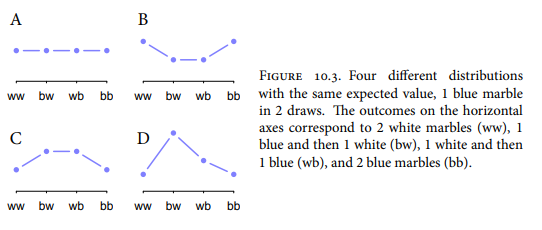

In [9]:
display(Image.open(os.path.join(os.getcwd(),r'data/entropy_marbles.png')))

In [10]:
p_1 = [1/4, 1/4, 1/4, 1/4]
p_2 = [2/6, 1/6, 1/6, 2/6]
p_3 = [1/6, 2/6, 2/6, 1/6]
p_4 = [1/8, 4/8, 2/8, 1/8]

p = [p_1, p_2, p_3, p_4]
obs = [0, 1, 1, 2]

In [11]:
expected_value = [np.dot(i, [0, 1, 1, 2]) for i in p]
print(expected_value)

[1.0, 0.9999999999999999, 1.0, 1.0]


In [12]:
ent = [entropy(i) for i in p]
print(ent)

[1.3862943611198906, 1.3296613488547582, 1.3296613488547582, 1.2130075659799042]


#### Distribution A, the binomial distribution, has the largest entropy among the four. To appreciate why, consider that information entropy increases as a probability distribution becomes more even. Distribution A is a flat line, as you can see in Figure 10.3. It can’t be made any more even, and each of the other distributions is clearly less even. That’s why they have smaller entropies. And since distribution A is consistent with the constraint that the expected value be 1, it follows that distribution A, which is binomial, has the maximum entropy of any distribution with these constraints

### A case where the expected value is not 1

####  Suppose for our second example that the expected value must be instead 1.4 blue marbles in two draws. This corresponds to p = 0.7. So you can think of this as 7 blue marbles and 3 white marbles hidden inside the bag. The binomial distribution with this expected value is:

In [13]:
p = 0.7
a = [(1-p)**2, p*(1-p), (1-p)*p, p**2]

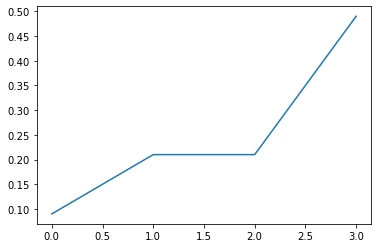

In [14]:
# This distribution is clearly not flat
plt.plot(a)

In [15]:
# It's entropy is 
-1*sum(a*np.log(a))

1.221728604109787

#### To appreciate how this distribution has maximum entropy—is the flattest distribution with expected value 1.4—we’ll simulate a bunch of distributions with the same expected value and then compare entropies.

#### This function generates a random distribution with expected value G and then returns its entropy along with the distribution. We want to invoke this function a large number of times (e.g. 100,000 times). 

In [16]:
def entropy_sims(G=1.4):
    x_123 = np.random.uniform(size=3)
    x_4 = (G*sum(x_123)-x_123[1] - x_123[2])/(2-G)
    combined = np.concatenate((x_123, [x_4]))
    z = sum(combined)
    p = combined/z
    H = -1*np.sum(p*np.log(p))
    
    return H, p

In [17]:
def replicate(times):
    H = np.zeros(times)
    p = np.zeros((times, 4))
    
    for i in range(times):
        h, _p = entropy_sims()
        H[i] = h
        p[i] = _p
    return H, p

#### The array H now holds 100000 probability distributions and their calculated entropies. Thedistribution of entropies is shown below.

In [18]:
H, p = replicate(100_000)

Text(0, 0.5, 'Density')

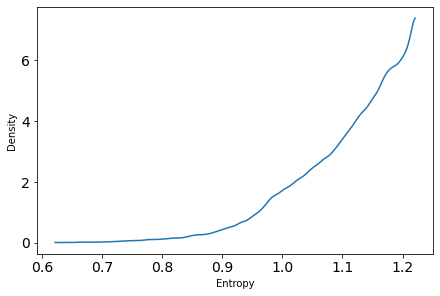

In [19]:
az.plot_kde(H)
plt.xlabel("Entropy")
plt.ylabel("Density")

#### What is the largest observed entropy?

In [20]:
np.max(H)

1.2217242021899857

#### That value is nearly identical to the entropy of the binomial distribution we calculated before. And the distribution with that entropy is:

In [21]:
p[np.argmax(H)]

array([0.09020178, 0.208889  , 0.21070745, 0.49020178])

#### And that’s almost exactly {0.09, 0.21, 0.21, 0.49}, the distribution we calculated earlier.


### Key takeaway
#### The principle of maximum entropy provides an empirically successful way to choose likelihood functions. Information entropy is essentially a measure of the number of ways a distribution can arise, according to stated assumptions. By choosing the distribution with the biggest information entropy, we thereby choose a distribution that obeys the constraints on outcome variables, without importing additional assumptions. Generalized linear models arise naturally from this approach, as extensions of the linear models in previous chapters. The necessity of choosing a link function to bind the linear model to the generalized outcome introduces new complexities in model specification, estimation, and interpretation.
